# Combined slice timing and motion correction

Nipy has a routine that combines the calculation of the motion between scans, and the slice time interpolation.

You can imagine that, as the motion correction moves the slices, we might want to take into account the fact that the slices in the images now correspond to different times of acquisition.

Nipy has a routine that does that by combining slice time correction with simultaneous motion correction.

See:

Roche, Alexis (2011) A four-dimensional registration algorithm with application
to joint correction of motion and slice timing in fMRI. *Medical Imaging, IEEE
Transactions on*;  30:1546--1554

In [1]:
import numpy as np

In [2]:
# - make numpy print numbers to 4dp only
np.set_printoptions(precision=4, suppress=True)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

We load the 4D image to which we will apply the algorithm:

In [4]:
import nipy

In [5]:
img = nipy.load_image('ds114_sub009_t2r1.nii')

To calculate the slice timing, we need the image TR.  In our case, we can see the TR recorded in the `db_name` and `pixdim` fields of the header, but this is often not the case, and we will have to get the TR from some other source such as the original DICOM files or our lab notebook written when we acquired the data.

In [6]:
print(img.metadata['header'])

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : ?TR:2500.000 TE:50
extents         : 0
session_error   : 0
regular         : r
dim_info        : 0
dim             : [  4  64  64  30 173   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.   4.   4.   4.   2.5  1.   1.   1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : 
aux_file        : 
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.9958999753
quatern_d       : -0.0904608666897
qoffset_x       : 124.244003296
qoffset_y       : -103.449684143
qoffset_z    

In fact nipy has taken the TR information out of the header, and put it into the 4th row, 4th column of the 5D affine matrix for this image:

In [7]:
img.affine

array([[  -4.    ,    0.    ,    0.    ,    0.    ,  124.244 ],
       [   0.    ,    3.9345,    0.7207,    0.    , -103.4497],
       [   0.    ,   -0.7207,    3.9346,    0.    ,  -33.4929],
       [   0.    ,    0.    ,    0.    ,    2.5   ,    0.    ],
       [   0.    ,    0.    ,    0.    ,    0.    ,    1.    ]])

In [8]:
TR = img.affine[3, 3]
TR

2.5

Before we get going, we drop the first four scans because of the T1 effect (see the diagnostics notebook):

In [9]:
img = img[..., 4:]

Now we are ready to do the combined motion and slice-time correction.

In [10]:
import nipy.algorithms.registration as reg

We have to specify the times at which the slices were acquired, relative to the beginning of the volume.  We can do this by passing in the times as an array, or by passing in a function that returns the times, given the TR and number of slices, but we can also select common schemes by passing in a string such as "ascending" (slices acquired sequentially from bottom to top).  Here we've specified that this acquisition acquired the second slice in space first in time, and then alternate slices to the top slice, followed by the first slice in space, and alternate slices to the top slice. We call this `asc_alt_2_1` - but see `nipy.algorithms.slicetiming.timefuncs` for a collection of these functions with their standard names.

`slice_info=2` tells nipy that the third image axes is the slice axis - meaning that the first slice collected in time was `img[:, :, 1, 0]`, the second slice collected was `img[:, :, 3, 0]` and so on.

In [11]:
realigner = reg.SpaceTimeRealign(img, TR, 
                                slice_times='asc_alt_2_1',
                                slice_info=2)

The estimation step takes a fairly long time:

In [12]:
realigner.estimate()

The estimation step results in a list of transforms, one list for each run.  We only have one run, so we have a list with a single entry:

In [13]:
transforms = realigner._transforms
len(transforms)

1

Each list has a transform object corresponding to every volume in the run.  These transform objects give the transformation to match each scan to the first:

In [14]:
run_0_xforms = transforms[0]
len(run_0_xforms)

169

In [15]:
run_0_xforms[0]

In [16]:
affines = [t.as_affine() for t in run_0_xforms]
print(affines[0])
print(affines[1])

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
[[ 1.     -0.0002 -0.0003  0.0091]
 [ 0.0002  1.      0.0011  0.0538]
 [ 0.0003 -0.0011  1.     -0.0132]
 [ 0.      0.      0.      1.    ]]


We can get the translations and rotations from the affines, like this:

In [17]:
translations = np.array([aff[:3, 3] for aff in affines])
translations.shape

(169, 3)

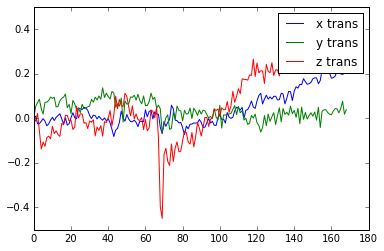

In [18]:
plt.plot(translations[:, 0], label='x trans')
plt.plot(translations[:, 1], label='y trans')
plt.plot(translations[:, 2], label='z trans')
plt.legend()

It takes a little more math to get the rotation (Euler) angles out of the affines, but not much:

In [19]:
rotations = np.array([reg.aff2euler(aff) for aff in affines])

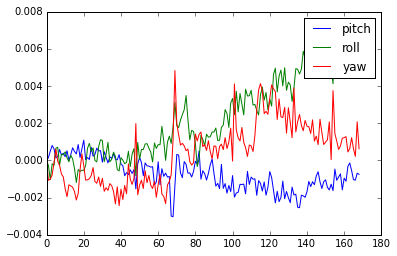

In [20]:
plt.plot(rotations[:, 0], label='pitch')
plt.plot(rotations[:, 1], label='roll')
plt.plot(rotations[:, 2], label='yaw')
plt.legend()

Finally, we can generate a new 4D image with the estimated slice time and motion effects removed, using the `resample` method of the realigner object:

In [21]:
resampled = realigner.resample()
resampled

[Image(
   data=array([[[[  0.      ,   0.000074, ...,   0.001222,   0.00045 ],
                 [  0.      ,   0.000085, ...,   0.000712,   0.001389],
                 ..., 
                 [  0.      ,   0.051972, ...,   0.      ,   0.      ],
                 [  0.      ,   0.058916, ...,   0.      ,   0.      ]],
        
                [[  8.      ,   8.71661 , ...,   6.583172,   6.394062],
                 [ 11.      ,   9.945651, ...,   8.784552,  10.173548],
                 ..., 
                 [ 19.      ,  19.464956, ...,  20.643818,  16.838831],
                 [ 28.      ,  24.863324, ...,  15.206551,  23.127875]],
        
                ..., 
                [[  0.      ,  -0.048841, ...,  -0.406789,  -0.30147 ],
                 [  0.      ,  -0.043404, ...,  -0.406128,  -0.192357],
                 ..., 
                 [  0.      ,  -0.024625, ...,  -0.005713,  -0.000287],
                 [  0.      ,  -0.013569, ...,   0.038333,  -0.005998]],
        
       